In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import os
import glob

import models.unet2dcondition as unet
import data.dataset_img as ds
import data.CI_torch_v2 as CI

import data.imgTransforms as imgTransforms

import ehtim as eh
import copy

from PIL import Image, ImageDraw
import imagehash


device = "mps" if torch.backends.mps.is_available() else "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

tforms = imgTransforms.imgTransforms()

# load model
model_name = 'Diffusion_M87_eht2022_230_thnoise_1'

# load encoder
encoder = 'models/saved_models/DIReCT_v2.pt'
encoder = torch.load(encoder, weights_only=False, map_location=device).module.to(device)



Welcome to eht-imaging! v 1.2.10 

Using device: cuda:1


In [2]:
def nxcorr(outputs, labels):
    dim = int(outputs.shape[-1])
    outputs = outputs.reshape(-1, dim**2)
    labels = labels.reshape(-1, dim**2)
    
    outputs_norm = (outputs.reshape(-1, dim, dim) - torch.nanmean(outputs, axis=1).reshape(-1, 1, 1)) / torch.std(outputs, axis=1).reshape(-1, 1, 1)
    labels_norm = (labels.reshape(-1, dim, dim) - torch.nanmean(labels, axis=1).reshape(-1, 1, 1)) / torch.std(labels, axis=1).reshape(-1, 1, 1)

    fft_outputs = torch.fft.fftn(outputs_norm, s=[outputs_norm.size(d)*1 for d in [1,2]], dim=[1,2])
    fft_labels = torch.fft.fftn(labels_norm, s=[outputs_norm.size(d)*1 for d in [1,2]], dim=[1,2])

    xcorr = torch.fft.ifftn(fft_outputs * torch.conj(fft_labels), dim=[1,2])

    nxcorr_flat = xcorr.reshape(-1, dim**2)
    idx = torch.argmax(torch.abs(nxcorr_flat), dim=1)

    return idx, torch.abs(nxcorr_flat[torch.arange(nxcorr_flat.shape[0]), idx])/dim**2

def shift_image(im1, im2): # shift single im2 by idx
    idx, _ = nxcorr(im1, im2)
    im2 = torch.roll(im2, shifts=int(idx))
    return im1, im2

def shift_all(truth, imgs):
    shifted_imgs = []
    for img in imgs:
        _, shifted_img = shift_image(truth, img)
        shifted_imgs.append(shifted_img)
    return np.array(shifted_imgs)

def weighted_mean_image(imgs, invs, clObj, plot=False):
    recon_ci = clObj.FTCI_batch(64, imgs.reshape(-1, imgs.shape[-2], imgs.shape[-1])).reshape(-1, 1, invs.shape[-1])
    # recon_ci = clObj.FTCI(imgs.reshape(-1, imgs.shape[-2], imgs.shape[-1])).reshape(-1, 1, invs.shape[-1])
    loss = nn.L1Loss(reduction='none')

    ciloss = loss(invs, torch.Tensor(recon_ci))
    civar = ciloss.reshape(-1, invs.shape[-1]).var(dim=1)
    sse = (ciloss.reshape(-1, invs.shape[-1])**2).sum(dim=1)

    imgs = imgs.reshape(-1, 1, imgs.shape[-2], imgs.shape[-1])
    imgs = imgs[torch.argsort(sse)] # images sorted by loss

    weighted_image = torch.zeros_like(imgs[0])
    for i in range(imgs.shape[0]):
        weighted_image += imgs[i] * 1/civar[i]
    weighted_image /= civar.sum()

    if plot:
        # ci loss histogram
        fig, ax = plt.subplots(1, 1, figsize=(2,2))
        
        ax.hist(sse.detach().cpu().numpy(), bins='fd', edgecolor='black', linewidth=1.2)
        ax.set_xlabel('CI SSE')

    return imgs, weighted_image.detach().cpu().numpy()[0], sse

def plot_images(images, save=False, name='images', cmap='viridis', return_axes=False, show=True):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0), cmap=cmap)
        ax.axis('off')
    if save:
        direc = 'models/history/'+name+'/'
        os.makedirs(direc, exist_ok=True)
        # check next number
        num = 0
        while glob.glob(f'{direc}{name}_{num}.png'):
            num += 1
        plt.savefig(f'{direc}{name}_{num}.png')
    if show:
        plt.show()
    if return_axes:
        return axes

def findClusters(x, threshold=4, hashsize=6, type=0, verbose=False):
    # hash all images
    clusters = {}
    for img in x:
        PIL_img = Image.fromarray(img[0]/np.max(img[0])*255)
        hash = imagehash.phash(PIL_img, hash_size=hashsize)
        clusters[hash] = clusters.get(hash, []) + [PIL_img]

    # group all hashes that are only different by threshold
    if type == 0: # Clusters by distance from hashes ordered by L1Loss of closure invariants
        moved_hashes = []
        for ind, hash in enumerate(clusters.keys()):
            if ind != len(clusters.keys()) - 1 and hash not in moved_hashes:
                test = np.array([hash - b for b in list(clusters.keys())[ind+1:]])
                for i in np.array(list(clusters.keys())[ind+1:])[np.where(test <= threshold)]:
                    if i not in moved_hashes:
                        moved_hashes.append(i)
                        clusters[hash] += clusters[i]
        
        for i in moved_hashes:
            if i in clusters.keys():
                del clusters[i]
    else:
        grouping = {} # Clusters by continuous hash connections
        for ind, hash in enumerate(clusters.keys()):
            if ind != len(clusters.keys()) - 1:
                test = np.array([hash - b for b in list(clusters.keys())[ind+1:]])
                for i in np.array(list(clusters.keys())[ind+1:])[np.where(test <= threshold)]:
                    if i not in grouping:
                        grouping[i] = hash

        for i in dict(reversed(list(clusters.items()))):
            if i in grouping:
                clusters[grouping[i]] += clusters[i]
                clusters[i] = []

        empty_keys = []
        for i in clusters:
            if len(clusters[i]) == 0:
                empty_keys.append(i)
        for i in empty_keys:
            del clusters[i]

    if verbose:
        print('Number of Clusters: ' + str(len(clusters)))

    return clusters

def ordered_hash(x, target, hashsize=12, cmap='Greys', fide_type='nxcorr', plot=False, num_images = 10):
    PIL_img = Image.fromarray(target/np.max(target)*255)
    target_hash = imagehash.phash(PIL_img, hash_size=hashsize)
    ordered_images = []
    for img in x:
        PIL_img = Image.fromarray(img[0]/np.max(img[0])*255)
        if fide_type == 'hash':
            hash = imagehash.phash(PIL_img, hash_size=hashsize)
            ordered_images.append([1 - int(hash-target_hash)/hashsize**2, PIL_img])
        elif fide_type == 'nxcorr':
            xcorr = nxcorr(torch.tensor(img), torch.tensor(target))[1]
            ordered_images.append([xcorr, PIL_img])
        else:
            ordered_images.append([0, None])
    ordered_images = sorted(ordered_images, key=lambda x: x[0])[::-1]
    if plot:
        # flattened images
        images = ordered_images[:num_images]
        fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
        fig.subplots_adjust(hspace=0., wspace=0.)
        axes = axes.flatten()
        for ax, data in zip(axes, images):
            ax.imshow(data[1], cmap=cmap)
            ax.axis('off')
            ax.text(0.5, 0.9, '%.3f' % data[0], ha='center', va='center', fontsize=8, transform=ax.transAxes, c='white')
    return ordered_images

def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

def crps_score(truth, imgs):
    imgs = np.array(imgs)
    imgs = imgs.reshape(imgs.shape[0], -1)
    truth = truth.reshape(-1)

    imgs = np.array([i/np.sum(i) for i in imgs])
    truth = truth/np.sum(truth)
    crps_scores = []
    for i in range(imgs.shape[1]):
        out_pix = imgs[:, i]
        mean_out_pix = np.mean(out_pix)+0.1
        truth_pix = truth[i]
        x, y = ecdf(out_pix)
        step_fc = np.heaviside(x-truth_pix, 0.5)
        crps = np.trapz((y-step_fc)**2, x)
        crps_scores.append(crps)

    crps_scores = np.array(crps_scores).reshape(64, 64)
    tot_crps = np.sum(crps_scores)/(truth.shape[0])
    return tot_crps, crps_scores    


In [4]:
# Load the clObj

tint_sec = 5
tadv_sec = 600
tstart_hr = 0
tstop_hr = 24
psize = 1.7044214966184275e-11 # the DIReCT psize
bw_hz = [230E9]

avg_timescale = 600
ehtimAvg=True

imgdim = 64

uvfits_files = ['M87_eht2022_230_thnoise.uvfits']

mask = None

ttype='DFT'

clObj = CI.Closure_Invariants(tint_sec=tint_sec, tadv_sec=tadv_sec, tstart_hr=tstart_hr, tstop_hr=tstop_hr, bw_hz=bw_hz, psize=psize,
                                  uvfits_files = uvfits_files, avg_timescale=avg_timescale, ehtimAvg=ehtimAvg,
                                  ci_mask=mask, ttype=ttype, device=device)
orig_clObj = copy.deepcopy(clObj)

data_dim = clObj.FTCI(np.zeros((1, imgdim, imgdim))).shape[-1]

print('Data Dim: ', data_dim)

# Network
net = unet.UNet2DCondition(ci_dim=data_dim, model_choice=1, encoder_hid_dim=0).to(device).double()
noise_scheduler = net.scheduler



Loading uvfits:  M87_eht2022_230_thnoise.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Data Dim:  1294


Loading fits image:  Images/s_sgra.fits


0it [00:00, ?it/s]

CRPS: 0.00010913593273231514
Number of Clusters: 1


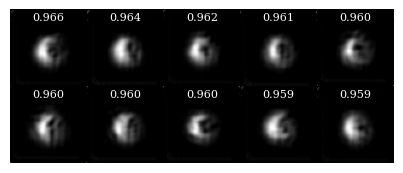

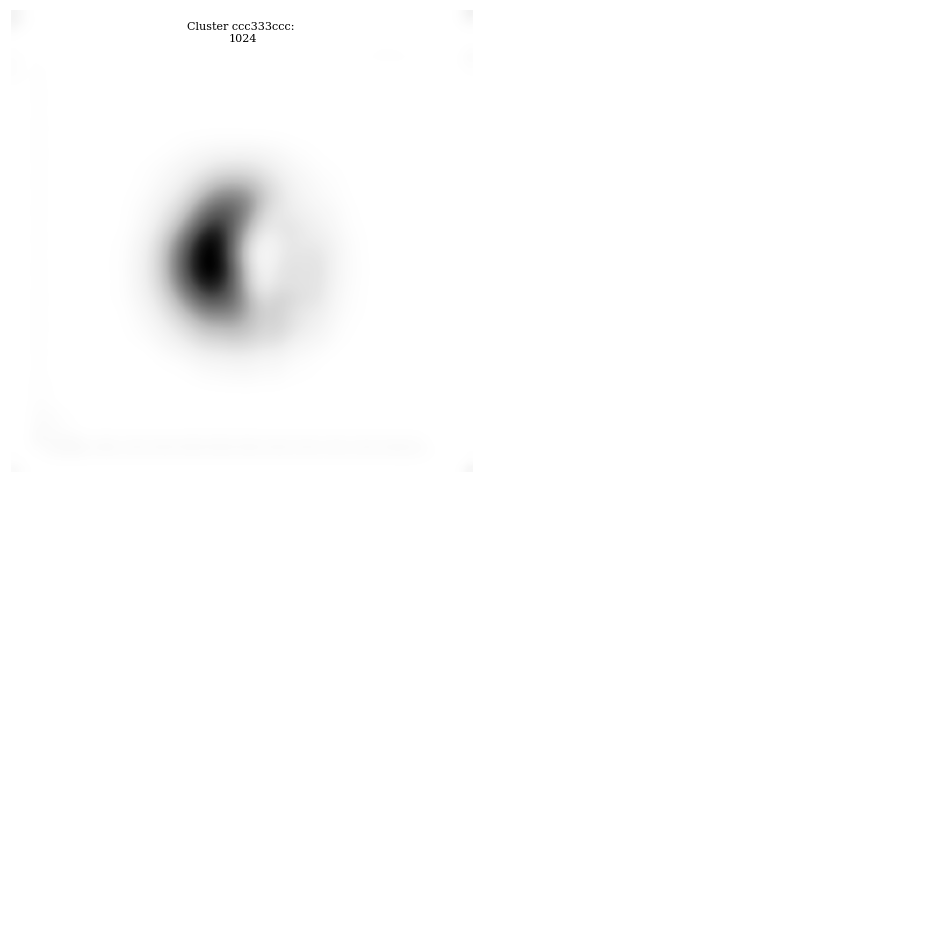

In [ ]:
# image clustering with hashing

N_images = 1024

load_fits = 'Images/s_sgra.fits'
useObs = False
clObj = copy.deepcopy(orig_clObj)

flux = 1.0

img = eh.image.load_fits(load_fits)
img._imdict['I'] = img.imarr().flatten()/np.sum(img.imarr().flatten()) * flux
orig_img = img.copy()

img.rf = bw_hz[0]

name = load_fits.split('/')[-1].split('.')[0]

# img = img.regrid_image(img.fovx(), imgdim)
# img.psize = psize
img = img.regrid_image(psize*imgdim, imgdim)


orig_img = img.copy()


im = img.imarr()

im = im/np.sum(im) * flux # normalise the intensity 

# load model from .pt
net.load_state_dict(torch.load('models/saved_models/'+model_name+'.pt', map_location=device))


x = torch.randn(N_images, 4, 16, 16).to(device)
im = torch.tensor(im).reshape(1, 1, 64, 64)#.repeat(N_images, 1, 1, 1)
invs = clObj.FTCI(im, useObs=useObs, add_th_noise=True, th_noise_factor=1)
invs = invs.to(device).repeat(N_images, 1)
invs = invs.reshape(-1, 1, invs.shape[-1])

invs = invs.to(torch.float32)
net = net.to(torch.float32)
x = x.to(torch.float32)

x = net.runUnet(x, invs, init_t=0, guidance_scale=None)


x = encoder.decoder(x.to(torch.float32))
x, x_mean, ciloss = weighted_mean_image(x.cpu(), invs.cpu(), clObj, plot=False)


# shift all images
x = shift_all(x[0].detach().cpu(), x.detach().cpu()) # according to best


print('CRPS: ' + str(crps_score(im.detach().numpy(), x)[0]))


clusters = findClusters(x, threshold=4, hashsize=6, type=1, verbose=True)
matched_imgs = ordered_hash(x, img.imarr(), hashsize=12, plot=True, fide_type='nxcorr', num_images=10)

ngrid = int(np.sqrt(len(clusters)))+1
fig, axs = plt.subplots(ngrid, ngrid, figsize=(12, 12))
fig.subplots_adjust(hspace=0, wspace=0)
axs = axs.flatten()
for a in axs:
    a.axis('off')


for ind, i in enumerate(clusters):
    PIL_imgs = clusters[i]
    c_images = [torch.tensor(np.asarray(i)) for i in PIL_imgs]
    c_rep = torch.tensor(c_images[0])
    c_images = shift_all(c_rep, c_images)
    c_invs = invs[:len(c_images)]
    c_images, c_mean, ciloss = weighted_mean_image(torch.tensor(c_images).unsqueeze(1), c_invs.cpu(), clObj)

    axs[ind].imshow(c_mean, cmap='Greys', interpolation='gaussian')
    axs[ind].text(0.5, 0.95, 'Cluster ' + str(i) + ': \n' + str(len(c_images)), ha='center', va='center', fontsize=8, transform=axs[ind].transAxes,)




Median CI SNR: 68.50


  0%|          | 0/1000 [00:00<?, ?it/s]

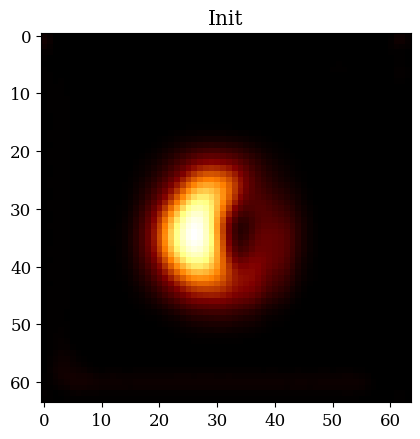

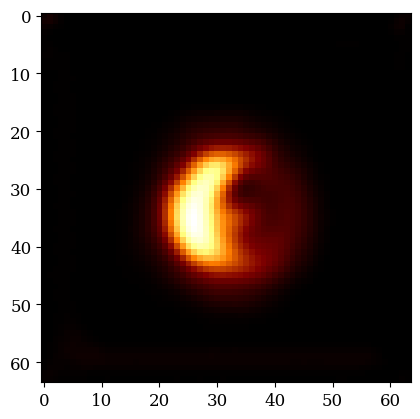

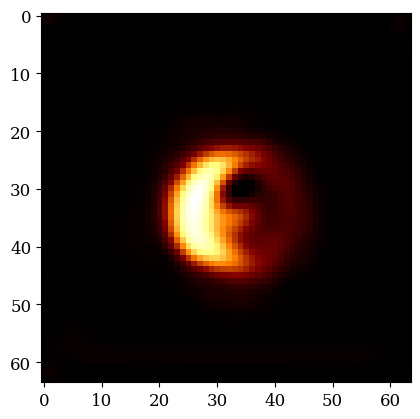

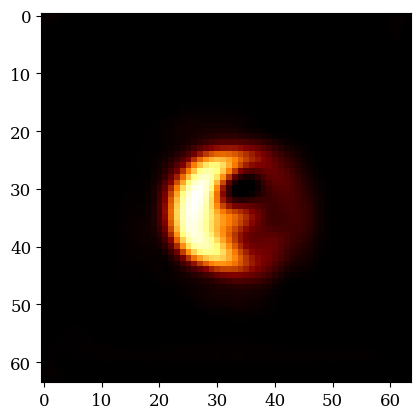

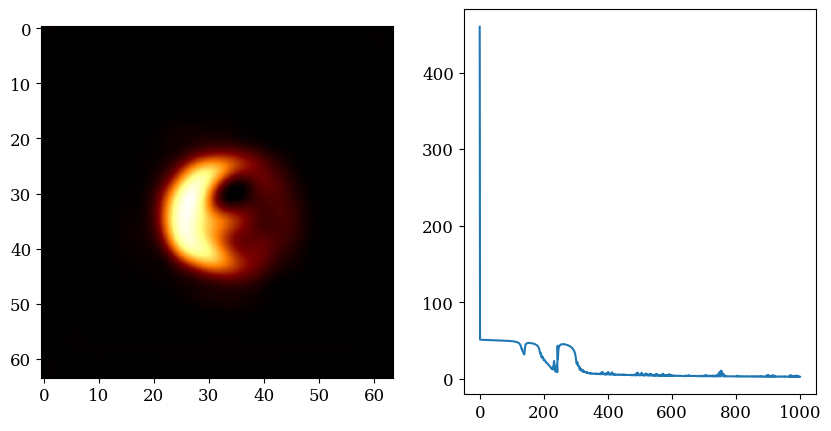

  0%|          | 0/2000 [00:00<?, ?it/s]

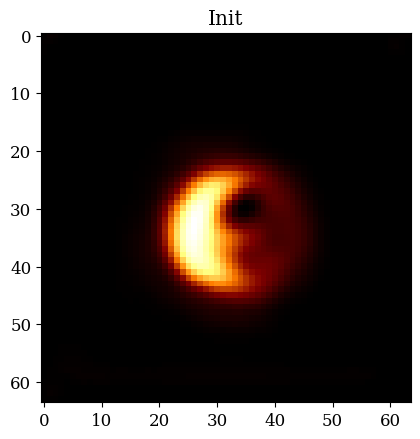

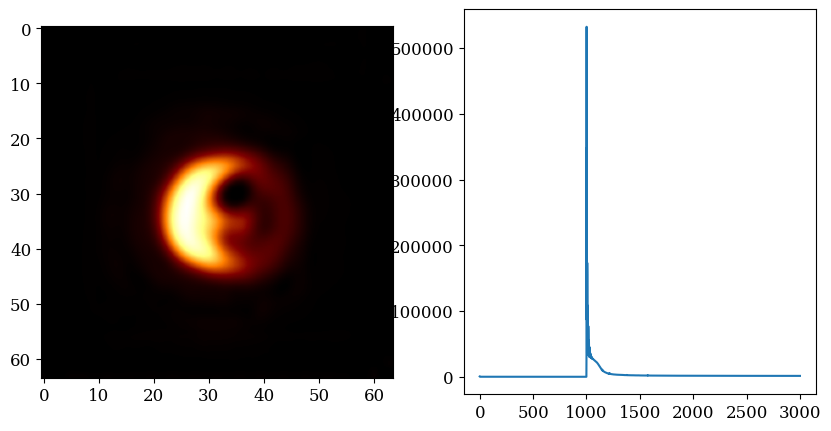

In [6]:
# convolutional averaging
import models.model_ImageConv as ConvModel

add_th_noise = not(useObs)
th_noise_factor = 1

if not useObs:
    clObj.replace_obs_vis(im.squeeze(0), xfov=225, yfov=225)

target_ci = invs[0].reshape(1, invs.shape[-1]).cpu()
ci_sigmas = clObj.get_CI_MCerror(im, n=1000, useObs=useObs, th_noise_factor=th_noise_factor)

print('Median CI SNR: %.2f' % torch.abs(target_ci/ci_sigmas).median())

convmodel = ConvModel.ImageConv(x, target_ci, ci_sigmas, clObj, interpF=lambda x: x/x.max(), device=device, interpFactor=1, psizeFactor=1).to(device)

convmodel.train(nepochs=1000, init_lr=1e-3, decay=0.999, verbose=True, loss_type='L1', weighting=True, loss_reduction='mean', optimiser='Adam')
convmodel.train(nepochs=2000, init_lr=1e-4, decay=0.999, verbose=False, loss_type='L2', loss_reduction='sum', optimiser='Adam')



Producing clean visibilities from image with direct FT . . . 
Logcamp chi2: 23.73
Cphase chi2: 1.06
CI chi2: 0.41


Text(0.97, 0.5, '$\\chi^2_{\\rm{cphase}} =$ 1.06\n$\\chi^2_{\\rm{lcamp}} =$ 23.73\n$\\chi^2_{\\rm{ci}} =$ 0.41')

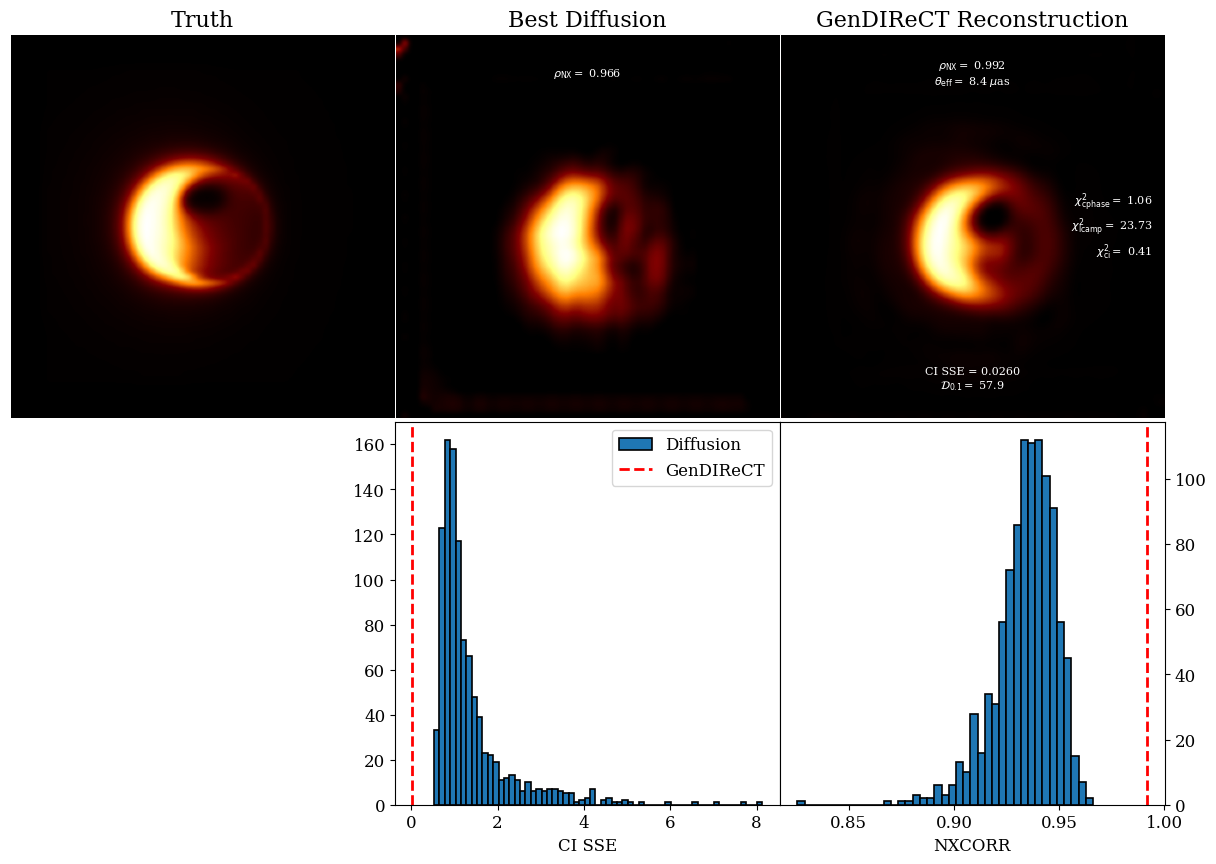

In [7]:
# Performance Metrics
import data.ngEHTMetrics as met

res = convmodel().detach().cpu().numpy()
out_res = img.copy()
out_res._imdict['I'] = res.flatten()/res.sum()

img_copy = orig_img.copy()
img_copy._imdict['I'] = orig_img.imvec/np.sum(orig_img.imvec)

metrics = met.Metrics(img_copy, out_res, clObj)

if not useObs:
    metrics.update_clObj()

chi2_cphase = metrics.chisq_cp()
chi2_lcamp = metrics.chisq_lcamp()
chi2_ci = metrics.chisq_ci(plot=False)
print('Logcamp chi2: %.2f' % chi2_lcamp)
print('Cphase chi2: %.2f' % chi2_cphase)
print('CI chi2: %.2f' % chi2_ci)


fig, ax =plt.subplots(2, 3, figsize=(14.9, 10))
fig.subplots_adjust(hspace=0.01, wspace=0.0)
titles = ['Truth', 'Best Diffusion', 'GenDIReCT Reconstruction']
img.display(axis=ax[0,0], cfun='afmhot', has_title=False, has_cbar=False)
ax[0,1].imshow(np.array(matched_imgs[1][1]), cmap='afmhot', interpolation='gaussian')
ax[0,2].imshow(res, cmap='afmhot', interpolation='gaussian')
for i, a in enumerate(ax.flatten()):
    if i < len(titles):
        a.axis('off')
        a.set_title(titles[i], fontsize=16)

ax[1,0].axis('off')

_, _, ciloss = weighted_mean_image(torch.tensor(x).cpu(), invs.cpu(), clObj, plot=False)
res_ciloss = nn.L1Loss(reduction='none')(target_ci, clObj.FTCI(torch.tensor(res).unsqueeze(0)))**2
res_ciloss = res_ciloss.sum(dim=1).detach().cpu().numpy()[0]

ax[1,1].hist(ciloss.detach().cpu().numpy(), bins='fd', edgecolor='black', linewidth=1.2, label='Diffusion')
ax[1,1].axvline(res_ciloss, color='red', linestyle='dashed', linewidth=2, label='GenDIReCT')
ax[1,1].set_xlabel('CI SSE')
ax[1,1].legend()

nxcorr_dist = [i[0][0].numpy() for i in matched_imgs]
res_nxcorr = nxcorr(torch.tensor(res), torch.tensor(im))[1].detach().cpu().numpy()[0]
ax[1,2].hist(nxcorr_dist, bins='fd', edgecolor='black', linewidth=1.2)
ax[1,2].axvline(res_nxcorr, color='red', linestyle='dashed', linewidth=2)
ax[1,2].set_xlabel('NXCORR')
ax[1,2].tick_params(left=False, labelleft=False, right=True, labelright=True)


effres = metrics.eff_res(plot=False)
dynrange = metrics.dynamic_range(effres)

ax[0,1].text(0.5, 0.9, '$\\rho_{\\rm{NX}} =$ %.3f' % matched_imgs[0][0].numpy(), ha='center', va='center', fontsize=8, transform=ax[0,1].transAxes, c='white')
ax[0,2].text(0.5, 0.9, '$\\rho_{\\rm{NX}} =$ %.3f\n$\\theta_{\\rm{eff}} =$ %.1f $\\mu$as' % (res_nxcorr, effres), ha='center', va='center', fontsize=8, transform=ax[0,2].transAxes, c='white')
ax[0,2].text(0.5, 0.1, 'CI SSE = %.4f\n$\\mathcal{D}_{0.1} =$ %.1f' % (res_ciloss, dynrange), ha='center', va='center', fontsize=8, transform=ax[0,2].transAxes, c='white')
ax[0,2].text(0.97, 0.5, '$\\chi^2_{\\rm{cphase}} =$ %.2f\n$\\chi^2_{\\rm{lcamp}} =$ %.2f\n$\\chi^2_{\\rm{ci}} =$ %.2f' % (chi2_cphase, chi2_lcamp, chi2_ci), ha='right', va='center', fontsize=8, transform=ax[0,2].transAxes, c='white')

